<a href="https://colab.research.google.com/github/SokichiFujita/PyTorch-for-Deep-Learning-and-Computer-Vision/blob/master/Chapter9_CIFAR_10_Classification_After_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() #create numpy array from tensor
  image = image.transpose(1, 2, 0)
  print(image.shape)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


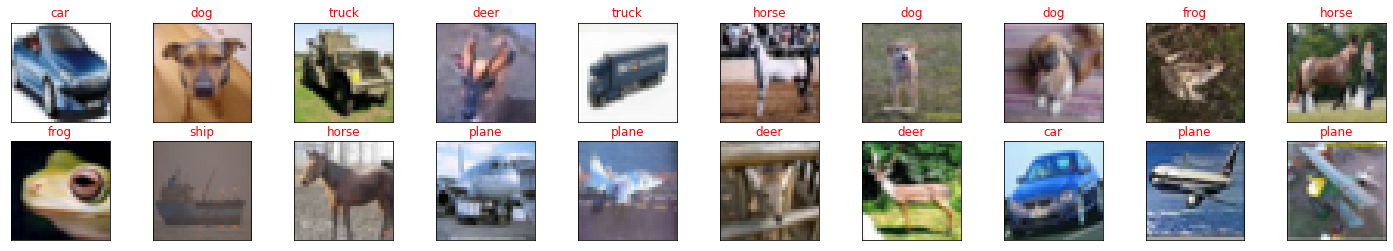

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[i]))
  ax.set_title(classes[labels[i].item()], color="red")

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # tune convolution layer
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # add one convolution and pool layer
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [8]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
# made steep learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: {} training loss: {:.7f}, accuracy: {:.7f} '.format(e+1, epoch_loss, epoch_acc.item()))
    print('epoch: {} validate loss: {:.7f}, accuracy: {:.7f} '.format(e+1, val_epoch_loss, val_epoch_acc.item()))


epoch: 1 training loss: 1.5927815, accuracy: 41.8940010 
epoch: 1 validate loss: 1.3350036, accuracy: 51.4099998 
epoch: 2 training loss: 1.2329313, accuracy: 55.7920036 
epoch: 2 validate loss: 1.1660015, accuracy: 58.6599998 
epoch: 3 training loss: 1.0483435, accuracy: 62.6100044 
epoch: 3 validate loss: 1.0158336, accuracy: 64.1100006 
epoch: 4 training loss: 0.9270994, accuracy: 67.3220062 
epoch: 4 validate loss: 0.9336873, accuracy: 67.5400009 
epoch: 5 training loss: 0.8374426, accuracy: 70.6320038 
epoch: 5 validate loss: 0.9245008, accuracy: 68.0800018 
epoch: 6 training loss: 0.7715140, accuracy: 72.8100052 
epoch: 6 validate loss: 0.8861466, accuracy: 69.3300018 
epoch: 7 training loss: 0.7154516, accuracy: 74.8160019 
epoch: 7 validate loss: 0.8636549, accuracy: 70.4599991 
epoch: 8 training loss: 0.6635939, accuracy: 76.6700058 
epoch: 8 validate loss: 0.8372933, accuracy: 71.0299988 
epoch: 9 training loss: 0.6170391, accuracy: 78.4240036 
epoch: 9 validate loss: 0.85703

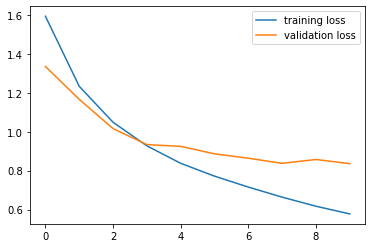

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

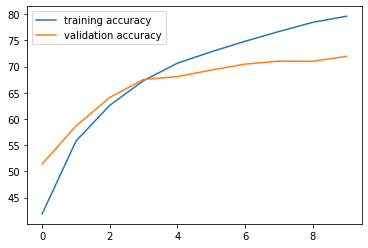

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [13]:
!pip3 install pillow

In [0]:
import requests
from PIL import Image

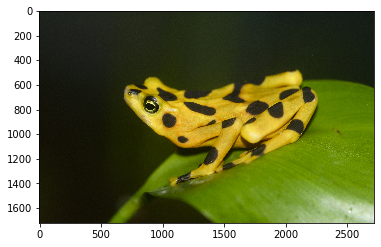

In [15]:
url = 'https://upload.wikimedia.org/wikipedia/commons/5/55/Atelopus_zeteki1.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(32, 32, 3)


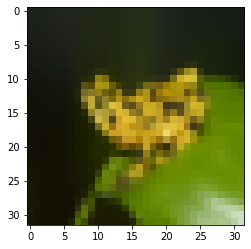

In [16]:
img = transform(img)
plt.imshow(image_convert(img))

In [17]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


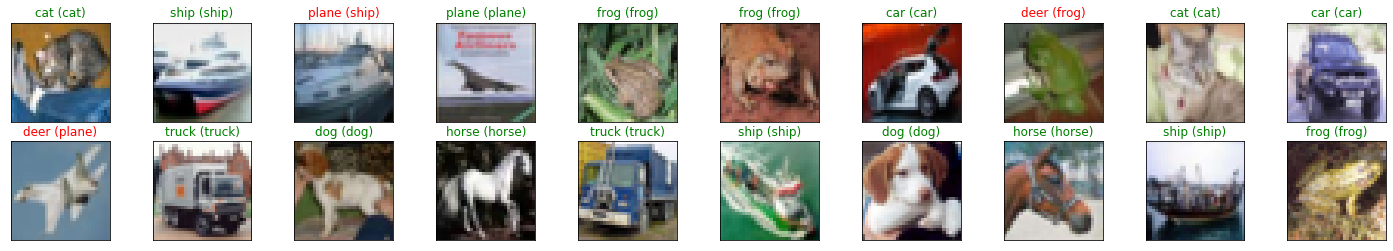

In [18]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))